# Softmax Classifier

**This material is heavily based on the popular Standford CS231n lecture material.** [Please check on their website for more detailed information](https://cs231n.github.io/).

In [3]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.size": 10,
})

from utils import *

np.set_printoptions(precision=5, suppress=True)

## Class Softmax

This is the implementation of the linear Softmax classifier:
* The Python class has two metods: `train(X, Y)` and `Y = predict(X)`.
* Matrix `self.W` is the weight matrix and also includes the bias vector ([bias tricks](https://cs231n.github.io/linear-classify/#interpreting-a-linear-classifier)).
* Training is done by using __stochastic gradient descent method__ or **gradient descent method**.

Let us define the score function as linear combination of all feature values.

$ F = X W$

$ \text{softmax}(i) = e^{F_{Y_{i}}} \Big/ \sum_{j=1}^C e^{F_{i}} $

$ L_{i}=-\log \left( \text{softmax}(i) \right) $

$ L=\underbrace{\frac{1}{N} \sum_{i=1}^N L_{i}}_{\text {data loss }}+\underbrace{\lambda R(W)}_{\text {regularization loss }} $

$ R(W) = \sum_{k=1}^C \sum_{l=1}^{D+1} W_{l, k}^{2} $

where:
- the dataset contains $N$ samples of data
- each sample has $D$ features (dimensionalities) and $C$ labels/classes (distinct categories)
- $X \in \mathbb{R}^{N \times (D+1)}$ contains the features from N samples of data
- $X_i \in \mathbb{R}^{D+1}$ contains the features of the $i$-th sample ($i$-th row of $X$)
- $Y \in \mathbb{R}^{N}$ contains the labels from N samples of data
- $Y_i \in \mathbb{R}$ contains the label of the $i$-th sample ($i$-th row of $Y$)
- $F_i \in \mathbb{R}^{C}$ is the scores for all classes of $i$-th sample
- $F_{y_i} \in \mathbb{R}$ is the score for the correct class of $i$-th sample
- $L \in \mathbb{R}$ is the total loss
- $L_i \in \mathbb{R}$ is the loss of $i$-th sample
- $W \in \mathbb{R}^{(D+1) \times C}$ is the weight matrix (with augmented bias vector in the last row)
- $R \in \mathbb{R}$ is the regularization loss

In [ ]:
from numba import njit, prange

class Softmax():
    @staticmethod
    @njit(parallel=True, fastmath=True)
    def softmax_loss(W, X, Y, reg):
        """
        Inputs have dimension D, there are C classes, and we operate on minibatches
        of N examples.

        Inputs:
        - W: A numpy array of shape (D+1, C) containing weights.
        - X: A numpy array of shape (N, D) containing a minibatch of data.
        - Y: A numpy array of shape (N,) containing training labels; Y[i] = c means
          that X[i] has label c, where 0 <= c < C.
        - reg: (float) regularization strength

        Returns a tuple of:
        - loss: loss as single float
        - dW: gradient with respect to weights W; an array of same shape as W

        References:
        - https://github.com/lightaime/cs231n
        - https://github.com/mantasu/cs231n
        - https://github.com/jariasf/CS231n
        
        """
        # Initialize the loss and gradient to zero.
        loss = 0.0
        dW   = np.zeros_like(W)
        
        N = X.shape[0] # samples 
        C = W.shape[1] # classes
        X = np.hstack((X, np.ones((N, 1)))) # the last column is 1: to allow augmentation of bias vector into W

        F = X@W 

        # Softmax Loss
        for i in prange(N):
            Fi = F[i] - np.max(F[i])
            expFi = np.exp(Fi)
            softmax = expFi/np.sum(expFi) 
            loss += -np.log(softmax[Y[i]])

            # Weight Gradients
            for j in prange(C):
                dW[:, j] += X[i] * softmax[j]
            dW[:, Y[i]] -= X[i]

        # Average and regulation
        loss = loss /  N + reg * np.sum(W * W)
        dW = dW / N + reg * 2 * W 

        return loss, dW
    
    
    @staticmethod
    def softmax_loss_vectorized(W, X, Y, reg):
        """
        Inputs have dimension D, there are C classes, and we operate on minibatches
        of N examples.

        Inputs:
        - W: A numpy array of shape (D+1, C) containing weights.
        - X: A numpy array of shape (N, D) containing a minibatch of data.
        - Y: A numpy array of shape (N,) containing training labels; Y[i] = c means
          that X[i] has label c, where 0 <= c < C.
        - reg: (float) regularization strength

        Returns a tuple of:
        - loss: loss as single float
        - dW: gradient with respect to weights W; an array of same shape as W

        References:
        - https://github.com/lightaime/cs231n
        - https://github.com/mantasu/cs231n
        - https://github.com/jariasf/CS231n
        
        """
        # Initialize the loss and gradient to zero.
        loss = 0.0
        dW   = np.zeros_like(W)
        
        N = X.shape[0] # samples 
        C = W.shape[1] # classes
        X = np.hstack((X, np.ones((N, 1)))) # the last column is 1: to allow augmentation of bias vector into W

        F = X@W 
        
        # Softmax Loss
        F = F - np.max(F, axis=1).reshape(-1,1)
        expF = np.exp(F)
        softmax = expF/np.sum(expF, axis=1).reshape(-1,1) 
        loss = np.sum(-np.log(softmax[range(N),Y])) / N + reg * np.sum(W * W)

        # derivative of the loss
        softmax[range(N), Y] -= 1                  # update the softmax table
        dW = X.T @ softmax / N + 2 * reg * W       # calculate gradient

        return loss, dW

    
    def train(self, X, Y, learning_rate=1e-3, reg=1, num_iters=100, batch_size=200, verbose=True, verbose_step=1000):
        '''
        Train this linear classifier using stochastic gradient descent.
        Setting the 'batch_size=None" turns of the stochastic feature.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        - Y: A numpy array of shape (N,) containing training labels; y[i] = c
          means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - reg: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.
        - verbose_steps: (integer) print proress once every verbose_steps

        Outputs:
        A list containing the value of the loss function at each training iteration.
        '''
          
        N, D = X.shape
        C = len(np.unique(Y)) 
        
        # lazily initialize W
        self.W = 0.001 * np.random.randn(D+1, C) # dim+1, to bias vector is augmented into W 

        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None

            # Sample batch_size elements from the training data and their           
            # corresponding labels to use in this round of gradient descent.        
            # Store the data in X_batch and their corresponding labels in           
            # y_batch; after sampling X_batch should have shape (dim, batch_size)   
            # and y_batch should have shape (batch_size,)                           
            
            if batch_size is not None:
              batch_indices = np.random.choice(N, batch_size, replace=False)
              X_batch = X[batch_indices]
              y_batch = Y[batch_indices]
              loss, grad = self.softmax_loss_vectorized(self.W, X_batch, y_batch, reg)
            else:
              loss, grad = self.softmax_loss_vectorized(self.W, X, Y, reg)
            
            loss_history.append(loss)

            # Update the weights using the gradient and the learning rate.          
            self.W = self.W - learning_rate * grad
     
            if verbose and it % verbose_step == 0 or (it == num_iters - 1):
                print('iteration %d / %d: loss %f' % (it, num_iters, loss), flush=True)

        return loss_history
    

    def predict(self, X):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.

        Returns:
        - Y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        
        X  = np.hstack((X, np.ones((X.shape[0],1))))

        Y_pred = np.zeros(X.shape[0])
        scores = X @ self.W
        Y_pred = scores.argmax(axis=1)

        return Y_pred

## Breast Cancer Wisconsin

This dataset is publicly available and can be downloaded from [this link](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic).

[This dataset is also available as one of scikit-learn example datasets](https://scikit-learn.org/1.5/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer
).

The original labels are characters: `M` and `B`. For the SVM to work, the labels must be numbers. Hence, we change the labels:
* `M` is replaced with `1`
* `B` is replaced with `0`

### Load the Dataset

In [5]:
data = np.loadtxt("./datasets/breast_cancer/wdbc.data", delimiter=",", dtype=str)
X = np.float32(data[:, 2:12])  # 10 dimensions

# Diagnosis (M = malignant, B = benign)
Y = np.zeros(X.shape[0], dtype=np.int32) 
Y[np.where(data[:,1]=='M')] = 1
Y[np.where(data[:,1]=='B')] = 0

print("Dimension numbers :", X.shape[1])
print("Number of data    :", X.shape[0])
print("Labels            :", np.unique(Y))

Dimension numbers : 10
Number of data    : 569
Labels            : [0 1]


### Split The Dataset for Training and Test

In [6]:
X_train = X[0:400, :]
Y_train = Y[0:400]
X_test  = X[401:, :]
y_test  = Y[401:]

num_test = X_test.shape[0]

### Train the Classifier

In [21]:
classifier = Softmax()
loss_hist = classifier.train(X_train, Y_train, learning_rate=1e-6,batch_size=200, reg=0.1, num_iters=50000)

iteration 0 / 50000: loss 0.747449
iteration 1000 / 50000: loss 0.582506
iteration 2000 / 50000: loss 0.530746
iteration 3000 / 50000: loss 0.500916
iteration 4000 / 50000: loss 0.439454
iteration 5000 / 50000: loss 0.422741
iteration 6000 / 50000: loss 0.438380
iteration 7000 / 50000: loss 0.441105
iteration 8000 / 50000: loss 0.437067
iteration 9000 / 50000: loss 0.412231
iteration 10000 / 50000: loss 0.403660
iteration 11000 / 50000: loss 0.398023
iteration 12000 / 50000: loss 0.380753
iteration 13000 / 50000: loss 0.397903
iteration 14000 / 50000: loss 0.363854
iteration 15000 / 50000: loss 0.382722
iteration 16000 / 50000: loss 0.372394
iteration 17000 / 50000: loss 0.386581
iteration 18000 / 50000: loss 0.366370
iteration 19000 / 50000: loss 0.373519
iteration 20000 / 50000: loss 0.387529
iteration 21000 / 50000: loss 0.361273
iteration 22000 / 50000: loss 0.357477
iteration 23000 / 50000: loss 0.347691
iteration 24000 / 50000: loss 0.351981
iteration 25000 / 50000: loss 0.366750

### Plot the Loss

Plot the loss as a function of iteration number.

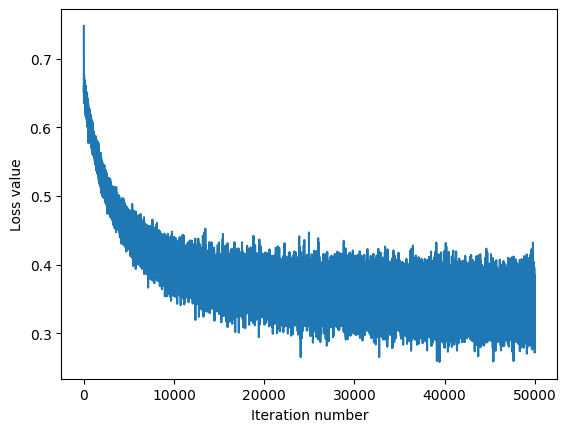

In [22]:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Test the Classifier
Evaluate the performance on both the training and validation set.

In [23]:
Y_train_pred = classifier.predict(X_train)
print('training accuracy: %f' % (np.mean(Y_train == Y_train_pred), ))
Y_test_pred = classifier.predict(X_test)
print('validation accuracy: %f' % (np.mean(y_test == Y_test_pred), ))

training accuracy: 0.852500
validation accuracy: 0.869048


## Handwritten Digits

This dataset is publicly available and can be downloaded from [this link](https://archive.ics.uci.edu/dataset/80/optical+recognition+of+handwritten+digits).

### Training Data

In [24]:
data = np.loadtxt("./datasets/handwritten_digits/optdigits.tra", delimiter=",", dtype=int)
X_train = np.int32(data[:, 0:-1])  
Y_train = np.int32(data[:, -1]) 

print("Dimension numbers :", X_train.shape[1])
print("Number of data    :", X_train.shape[0])
print("Labels            :", np.unique(Y_train))

Dimension numbers : 64
Number of data    : 3823
Labels            : [0 1 2 3 4 5 6 7 8 9]


### Test Data

In [25]:
data = np.loadtxt("./datasets/handwritten_digits/optdigits.tes", delimiter=",", dtype=int)
X_test = np.int32(data[:, 0:-1])  
Y_test = np.int32(data[:, -1]) 

print("Dimension numbers :", X_test.shape[1])
print("Number of data    :", X_test.shape[0])
print("Labels            :", np.unique(Y_test))

Dimension numbers : 64
Number of data    : 1797
Labels            : [0 1 2 3 4 5 6 7 8 9]


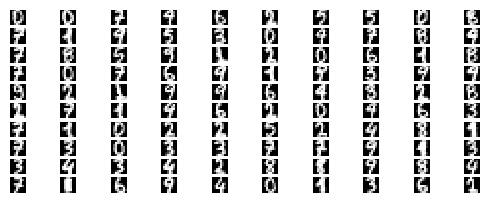

In [42]:
for i in range(100):
    X_train_ = X_train[i,:].reshape(8, 8)
    X_train_ = np.abs(255.0 - 255.0 / 16.0 * X_train_)
    plt.subplot(20, 10, i + 1)
    # Rescale the weights to be between 0 and 255
    plt.imshow(X_train_.astype('uint8'), cmap='Greys')
    plt.axis('off')

### Train the Classifier

In [38]:
classifier = Softmax()
loss_hist = classifier.train(X_train, Y_train, learning_rate=1e-5, batch_size=None, num_iters=100000, verbose_step=10000)

iteration 0 / 100000: loss 2.303241
iteration 10000 / 100000: loss 0.799148
iteration 20000 / 100000: loss 0.690610
iteration 30000 / 100000: loss 0.669709
iteration 40000 / 100000: loss 0.663781
iteration 50000 / 100000: loss 0.661664
iteration 60000 / 100000: loss 0.660775
iteration 70000 / 100000: loss 0.660356
iteration 80000 / 100000: loss 0.660143
iteration 90000 / 100000: loss 0.660029
iteration 99999 / 100000: loss 0.659966


### Plot the Loss

Plot the loss as a function of iteration number.

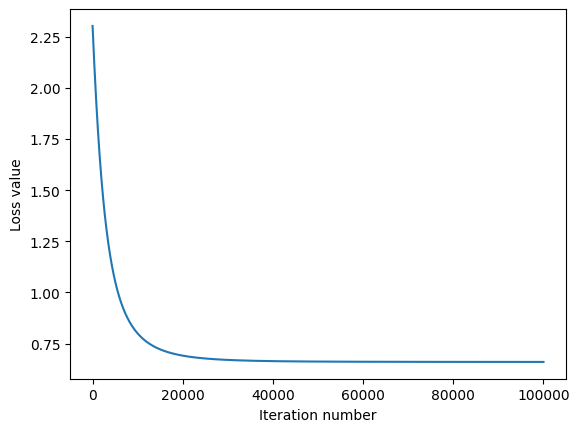

In [39]:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Test the Classifier

Evaluate the performance on both the training and validation set.

In [40]:
Y_train_pred = classifier.predict(X_train)
print('training accuracy: %f' % (np.mean(Y_train == Y_train_pred), ))
Y_test_pred = classifier.predict(X_test)
print('validation accuracy: %f' % (np.mean(Y_test == Y_test_pred), ))

training accuracy: 0.950301
validation accuracy: 0.928770


### Visualize the Learned Weights
* Take matrix `W` and strip out the bias. 
* For each class, reshape the matrix back into 2D arrays
* Plot the 2D arrays (matrices) as images.

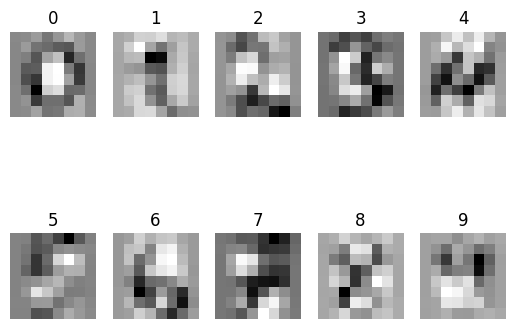

In [41]:
w = classifier.W[:-1, :] # strip out the bias
w = w.reshape(8, 8, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'), cmap='Greys')
    plt.axis('off')
    plt.title(classes[i])